# Unsupervised Learning: K-Means & GMM

## 0. Imports

In [27]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, adjusted_rand_score
import matplotlib.pyplot as plt
from scipy.stats import mode

## 1. Load the digits dataset from scikit-learn

In [11]:
digits = load_digits()
X, y = digits.data, digits.target

## 2. Choose only three classes

In [12]:
mask = np.isin(y, [ 0, 1, 2])
X, y = X[mask], y[mask]

## 3. PCA

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=0
    )
pca = PCA(n_components=2, random_state=0)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [14]:
X[0,20:30]

array([ 0., 11.,  8.,  0.,  0.,  4., 12.,  0.,  0.,  8.])

## 4. Run the built-in KMeans algorithm on the PCA-transformed data

In [20]:
# Apply KMeans clustering (3 clusters for digits 0, 1, 2)
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train_pca)
y_pred = kmeans.predict(X_test_pca)

## 5. Plot the KMeans clusters in the 2D space and compare them to the original digit labels

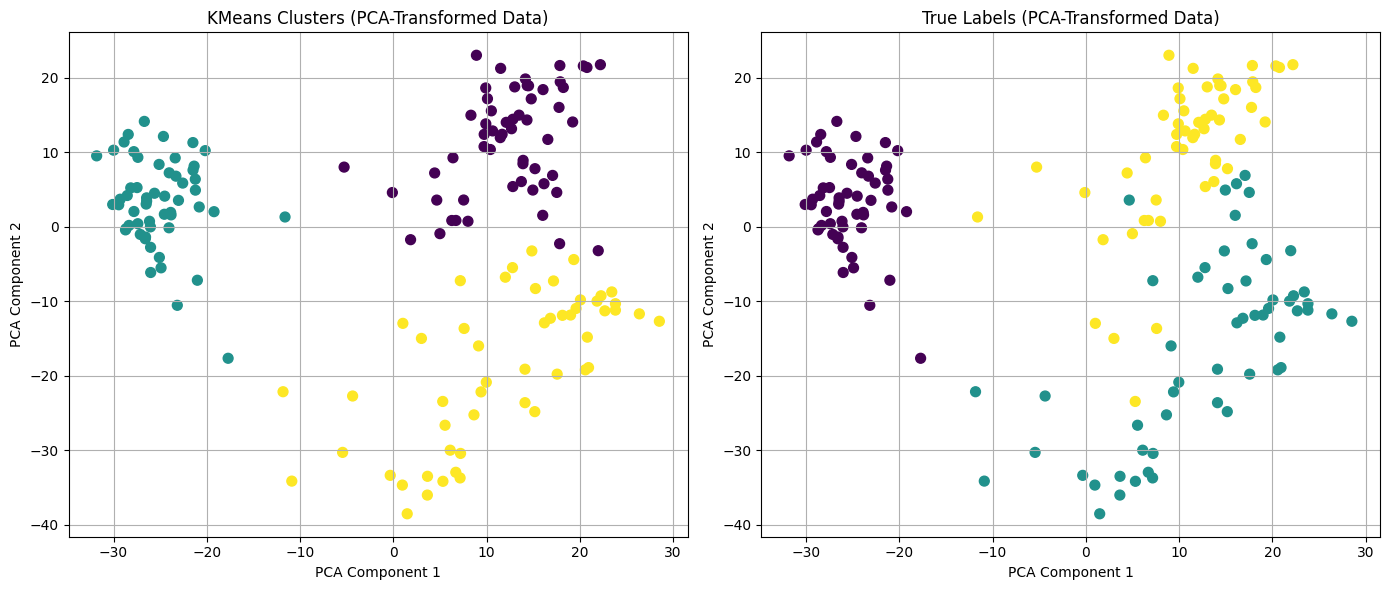

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='viridis', s=50)
axes[0].set_title("KMeans Clusters (PCA-Transformed Data)")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].grid(True)

axes[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', s=50)
axes[1].set_title("True Labels (PCA-Transformed Data)")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Conclusions:
1. KMeans is able to identify general patterns, but does not match 100% with the original labels:
In the left graph (KMeans), you can see that the clusters are distinct from each other, but they do not completely match the distribution of the real digits in the right graph.
The reason: KMeans does not know the labels – it clusters according to geometric distances only, not according to the symbolic meaning of the digits.

2. The rotation and layout directions are different:
A certain cluster in KMeans (for example, on the upper left side) probably corresponds to one group of digits – but the cluster number is different from the label number. For example: KMeans cluster 0 does not necessarily represent the digit 0.
This is a normal phenomenon – there is no direct correspondence between the cluster number and the digit number.

3. The cluster structure is consistent:
In both graphs, three clear clusters are visible, which shows that PCA was able to preserve good structure, and KMeans was able to identify the general clusters.
This indicates that PCA successfully reduced dimensionality while preserving the data structure.

In [25]:
# Mapping clusters to real labels by maximum matching
def map_clusters_to_labels(y_pred, y_true):
    labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = y_pred == cluster
        most_common = mode(y_true[mask], keepdims=True).mode[0]
        labels[mask] = most_common
    return labels

y_kmeans_mapped = map_clusters_to_labels(y_pred, y_test)

# accuracy calculate
accuracy = accuracy_score(y_test, y_kmeans_mapped)
print(f"Accuracy after mapping clusters to true labels: {accuracy:.4f}")

Accuracy after mapping clusters to true labels: 0.9198


## 6. "elbow" method to find the best value of k
#### plot inertia vs. k for k in a range (e.g., 1–10):

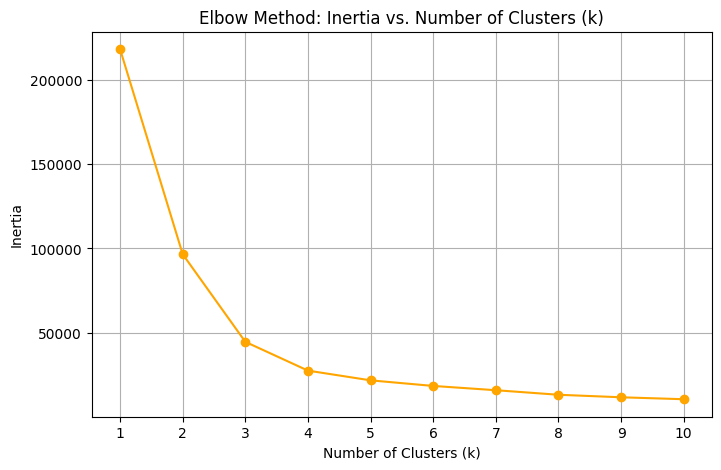

In [26]:
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_train_pca)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o', color='orange')
plt.title('Elbow Method: Inertia vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

The "elbow" occurs around k = 3.

The optimal number of clusters is probably 3 and this corresponds to the fact that we selected 3 classes from the data.

## 7. Run GaussianMixture (GMM) with two covariance types: 'full' and 'diag'.

In [39]:
from numpy.linalg import inv, det

# Define helper functions
def initialize_gmm(X, n_components):
    rng = np.random.RandomState(0)
    means = X[rng.choice(X.shape[0], n_components, replace=False)]
    covariances = np.array([np.cov(X.T) for _ in range(n_components)])
    weights = np.ones(n_components) / n_components
    return weights, means, covariances

def e_step(X, weights, means, covariances, cov_type):
    n_samples, n_features = X.shape
    n_components = len(weights)
    responsibilities = np.zeros((n_samples, n_components))
    for k in range(n_components):
        diff = X - means[k]
        cov = covariances[k] if cov_type == 'full' else np.diag(np.diag(covariances[k]))
        cov_inv = inv(cov)
        norm_const = 1. / np.sqrt((2 * np.pi) ** n_features * det(cov))
        responsibilities[:, k] = weights[k] * norm_const * np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

def m_step(X, responsibilities):
    n_samples, n_features = X.shape
    n_components = responsibilities.shape[1]
    weights = responsibilities.sum(axis=0) / n_samples
    means = (responsibilities.T @ X) / responsibilities.sum(axis=0)[:, np.newaxis]
    covariances = []
    for k in range(n_components):
        diff = X - means[k]
        cov = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / responsibilities[:, k].sum()
        covariances.append(cov)
    return weights, means, np.array(covariances)

def fit_gmm(X, n_components, cov_type='full', n_iter=100, tol=1e-4):
    weights, means, covariances = initialize_gmm(X, n_components)
    log_likelihoods = []
    for _ in range(n_iter):
        responsibilities = e_step(X, weights, means, covariances, cov_type)
        weights, means, covariances = m_step(X, responsibilities)
        # Compute log likelihood
        log_likelihood = 0
        for k in range(n_components):
            diff = X - means[k]
            cov = covariances[k] if cov_type == 'full' else np.diag(np.diag(covariances[k]))
            cov_inv = inv(cov)
            norm_const = 1. / np.sqrt((2 * np.pi) ** X.shape[1] * det(cov))
            log_likelihood += weights[k] * norm_const * np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
        total_log_likelihood = np.sum(np.log(log_likelihood))
        log_likelihoods.append(total_log_likelihood)
        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    return weights, means, covariances, responsibilities, log_likelihoods

def predict_gmm(X, weights, means, covariances, cov_type='full'):
    n_samples, n_features = X.shape
    n_components = len(weights)
    responsibilities = np.zeros((n_samples, n_components))
    for k in range(n_components):
        diff = X - means[k]
        cov = covariances[k] if cov_type == 'full' else np.diag(np.diag(covariances[k]))
        cov_inv = inv(cov)
        norm_const = 1. / np.sqrt((2 * np.pi) ** n_features * det(cov))
        responsibilities[:, k] = weights[k] * norm_const * np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities.argmax(axis=1)

def map_clusters_to_labels(y_pred, y_true):
    labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = y_pred == cluster
        most_common = mode(y_true[mask], keepdims=True).mode[0]
        labels[mask] = most_common
    return labels

# Run GMM for both covariance types and evaluate
results = {}
log_likelihoods_dict = {}

for cov_type in ['full', 'diag']:
    weights, means, covariances, _ , log_likelihoods = fit_gmm(X_train_pca, n_components=3, cov_type=cov_type)
    log_likelihoods_dict[cov_type] = log_likelihoods
    y_pred = predict_gmm(X_test_pca, weights, means, covariances, cov_type=cov_type)
    y_mapped = map_clusters_to_labels(y_pred, y_test)
    acc = accuracy_score(y_test, y_mapped)
    ari = adjusted_rand_score(y_test, y_pred)
    results[cov_type] = {'accuracy': acc, 'ari': ari}
results


{'full': {'accuracy': 0.8950617283950617, 'ari': 0.7261127605689257},
 'diag': {'accuracy': 0.8827160493827161, 'ari': 0.7006188540055301}}

Conclusions:
1. Both models perform well.
2. Full covariance (full) is slightly better. `full` allows each cluster to use a full covariance matrix – so it is more flexible and can adapt to complex cluster shapes.
3. Diagonal covariance (diag) is more economical. `diag` uses only the standard deviation for each feature, ignoring the dependencies between different features.

## 8. Plot the log-likelihood over EM iterations for each covariance type to verify it increases.

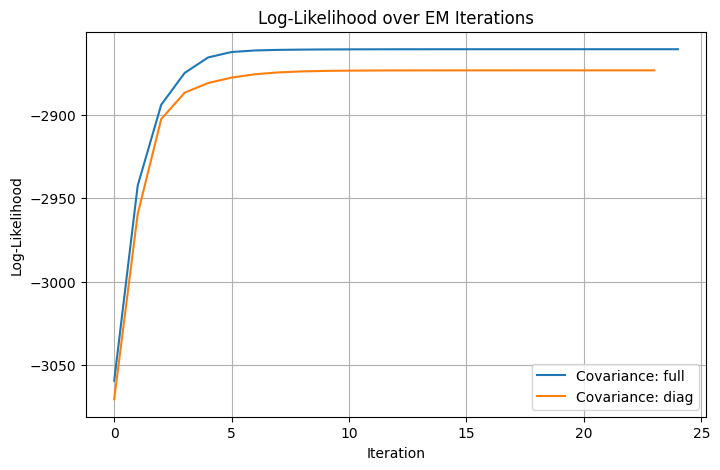

In [ ]:
# Plot the log-likelihoods
plt.figure(figsize=(8, 5))
for cov_type, ll in log_likelihoods_dict.items():
    plt.plot(ll, label=f"Covariance: {cov_type}")
plt.title("Log-Likelihood over EM Iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.grid(True)
plt.show()


Conclusions:
1. The algorithm converges properly:
Both lines (`full` and `diag`) show a monotonic increase in the log-likelihood value - that is, each iteration of the EM algorithm improves or preserves the objective function.
2. The `full` covariance converges to a higher value:
The blue line (`full`) reaches a higher log-likelihood value than the orange line (`diag`), indicating a model that better explains the data.
3. Rapid convergence:
Most of the log-likelihood improvement occurs within the first 5–7 iterations, and then the lines stabilize.